# Text Classification using CNN-LSTM and Pre-trained Glove Models

### Import libraries

In [1]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import numpy as np # for mathematic equation
from nltk.corpus import stopwords # to get collection of stopwords
from sklearn.model_selection import train_test_split # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences # to do padding or tru
from tensorflow.keras.models import Sequential # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint # save model
from tensorflow.keras.models import load_model

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yokes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df_full = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)

In [3]:
df = pd.DataFrame()
df['text'] = df_full.data
df['source'] = df_full.target
label=[]
for i in df['source']:
    label.append(df_full.target_names[i])
df['label']=label

In [4]:
df

,text,source,label
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware
...,...,...,...
18841,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,13,sci.med
18842,\nNot in isolated ground recepticles (usually ...,12,sci.electronics
18843,I just installed a DX2-66 CPU in a clone mothe...,3,comp.sys.ibm.pc.hardware
18844,\nWouldn't this require a hyper-sphere. In 3-...,1,comp.graphics


In [5]:
x_data = df['text'] # Reviews/Input
y_data = df['source'] # Sentiment/Output

In [6]:
def load_dataset():
    english_stops = set(stopwords.words('english'))

    x_data = df['text'] # Reviews/Input
    y_data = df['source'] # Sentiment/Output

    # PRE-PROCESS REVIEW
    x_data = x_data.replace({'<.*?>': ''}, regex = True) # remove html tag
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True) # remove non alphabet
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])
    x_data = x_data.apply(lambda review: [w.lower() for w in review]) # lower case
    
    return x_data, y_data

In [7]:
x_data, y_data = load_dataset()

print('text')
print(x_data)
print('source')
print(y_data)

text
0        [i, sure, bashers, pens, fans, pretty, confuse...
1        [my, brother, market, high, performance, video...
2        [finally, said, dream, mediterranean, that, ne...
3        [think, it, scsi, card, dma, transfers, not, d...
4        [i, old, jasmine, drive, i, cannot, use, new, ...
                               ...                        
18841    [dn, from, nyeda, cnsvax, uwec, edu, david, ny...
18842    [not, isolated, ground, recepticles, usually, ...
18843    [i, installed, dx, cpu, clone, motherboard, tr...
18844    [wouldn, require, hyper, sphere, in, space, po...
18845    [after, tip, gary, crum, crum, fcom, cc, utah,...
Name: text, Length: 18846, dtype: object
source
0        10
1         3
2        17
3         3
4         4
         ..
18841    13
18842    12
18843     3
18844     1
18845     7
Name: source, Length: 18846, dtype: int32


In [8]:
X_token = Tokenizer(num_words=5000,oov_token='<oov>') 
X_token.fit_on_texts(x_data)
word_index = X_token.word_index
X_sequence = X_token.texts_to_sequences(x_data) 
dict(list(word_index.items())[0:15])

{'<oov>': 1,
 'ax': 2,
 'i': 3,
 'the': 4,
 'x': 5,
 'm': 6,
 'one': 7,
 'a': 8,
 'would': 9,
 'w': 10,
 'q': 11,
 'b': 12,
 'g': 13,
 'f': 14,
 'v': 15}

In [9]:
X_padding= pad_sequences(X_sequence,maxlen=200,padding='post')

### Dataset Preparation

In [10]:
x_train,x_test,y_train,y_test=train_test_split(X_padding,y_data,test_size=.3)

In [11]:
print(x_train.shape,x_test.shape) 
print(y_train.shape,y_test.shape)

(13192, 200) (5654, 200)
(13192,) (5654,)


### LSTM Model Creation

In [12]:
vocab_size = 5000
embedding_dim = 64
max_length = 200

In [13]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim)) 
model.add(LSTM(embedding_dim)) 
model.add(Dense(embedding_dim, activation='tanh'))
model.add(Dense(20,activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 20)                1300      
                                                                 
Total params: 358,484
Trainable params: 358,484
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [16]:
history1=model.fit(x_train,y_train,epochs=20)

Epoch 1/20
413/413 [==============================] - 25s 57ms/step - loss: 2.8989 - accuracy: 0.0799
Epoch 2/20
413/413 [==============================] - 25s 60ms/step - loss: 2.7819 - accuracy: 0.0942
Epoch 3/20
413/413 [==============================] - 25s 60ms/step - loss: 2.8933 - accuracy: 0.0829
Epoch 4/20
413/413 [==============================] - 25s 60ms/step - loss: 2.8477 - accuracy: 0.0959
Epoch 5/20
413/413 [==============================] - 26s 62ms/step - loss: 2.7615 - accuracy: 0.1064
Epoch 6/20
413/413 [==============================] - 25s 61ms/step - loss: 2.7356 - accuracy: 0.1135
Epoch 7/20
413/413 [==============================] - 26s 62ms/step - loss: 2.7016 - accuracy: 0.1237
Epoch 8/20
413/413 [==============================] - 27s 65ms/step - loss: 2.7868 - accuracy: 0.1167
Epoch 9/20
413/413 [==============================] - 25s 60ms/step - loss: 2.6492 - accuracy: 0.1474
Epoch 10/20
413/413 [==============================] - 26s 62ms/step - loss: 2.629

### CNN-LSTM Model Creation

In [17]:
from tensorflow.keras.layers import Conv1D,MaxPooling1D

model2 = Sequential() 
model2.add(Embedding(vocab_size, embedding_dim))
model2.add(Conv1D(filters=32,kernel_size=5,strides=1,activation='relu')) 
model2.add(MaxPooling1D((2)))

model2.add(LSTM(embedding_dim))

model2.add(Dense(128,activation= 'relu')) 
model2.add(Dense(20,activation='softmax'))

In [18]:
model2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [19]:
history2=model2.fit(x_train,y_train,epochs=20)

Epoch 1/20
413/413 [==============================] - 18s 40ms/step - loss: 2.8852 - accuracy: 0.0774
Epoch 2/20
413/413 [==============================] - 16s 40ms/step - loss: 2.8220 - accuracy: 0.0867
Epoch 3/20
413/413 [==============================] - 16s 39ms/step - loss: 2.8220 - accuracy: 0.0882
Epoch 4/20
413/413 [==============================] - 17s 40ms/step - loss: 2.6525 - accuracy: 0.1124
Epoch 5/20
413/413 [==============================] - 17s 40ms/step - loss: 2.4081 - accuracy: 0.1521
Epoch 6/20
413/413 [==============================] - 17s 40ms/step - loss: 2.2350 - accuracy: 0.1876
Epoch 7/20
413/413 [==============================] - 16s 40ms/step - loss: 2.1132 - accuracy: 0.2201
Epoch 8/20
413/413 [==============================] - 17s 41ms/step - loss: 1.9795 - accuracy: 0.2511
Epoch 9/20
413/413 [==============================] - 17s 40ms/step - loss: 1.8467 - accuracy: 0.2844
Epoch 10/20
413/413 [==============================] - 17s 40ms/step - loss: 1.723

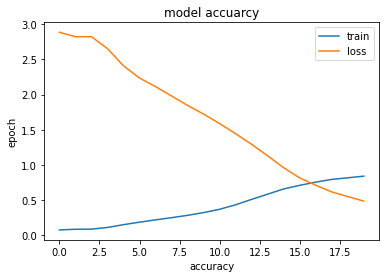

In [20]:
import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy']) 
plt.plot(history2.history['loss'])

plt.title('model accuarcy') 
plt.xlabel('accuracy') 
plt.ylabel('epoch')

plt.legend(['train','loss']) 
plt.show()


In [21]:
score = model2.evaluate(x_test,y_test,verbose=0)

print("loss:",score[0]) 
print("accuracy:",score[1])


loss: 3.0768606662750244
accuracy: 0.4533073902130127


### Pre-trained Model Creation

In [26]:
#Pre-trained Model Creation 
! wget --no-check-certificate \
    http://nlp.stanford.edu/data/glove.20B.zip \
    -O /tmp/glove.20B.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
